In [8]:
import openai
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import pickle
from tqdm import tqdm, trange
from IPython.display import display, Markdown, HTML
import re
from matplotlib.animation import FuncAnimation

from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval, AnswerRelevancyMetric, FaithfulnessMetric, HallucinationMetric
from deepeval.evaluate import evaluate, DisplayConfig

In [3]:
# --- Funkcje ---
def get_response(prompt, temperature=0.7):
    response = openai.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_tokens=300
    )
    return response.choices[0].message.content.strip()

def normalize_markdown(text):
    # usuń nagłówki i znaczniki
    text = re.sub(r"`{1,3}[^`]+`{1,3}", "", text)  # kod inline
    text = re.sub(r"#+\\s*", "", text)            # nagłówki
    text = re.sub(r"\\*\\*?|__?", "", text)        # pogrubienie/kursywa
    text = re.sub(r"!?\[.*?\]\(.*?\)", "", text)   # linki i obrazki
    text = re.sub(r"[\\*\\-\\_]{2,}", " ", text)   # linie poziome
    return text.strip()

def get_similarity(text1, text2):
    text1 = normalize_markdown(text1)
    text2 = normalize_markdown(text2)
    emb1 = embedding_model.encode([text1])[0]
    emb2 = embedding_model.encode([text2])[0]
    return cosine_similarity([emb1], [emb2])[0][0]

In [4]:
# --- Modele embeddingowe ---
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [2]:
# --- Parametry ---
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
openai.api_key = OPENAI_API_KEY
N_SIMULATIONS = 100
MODEL = 'gpt-4.1-nano'
TEMPERATURE = 0.2
PROMPT = "Wyjaśnij krótko, jak rośliny regulują fotosyntezę za pomocą efektów kwantowych."
REFERENCE = "Rośliny regulują fotosyntezę m.in. dzięki efektom kwantowym w antenach światłoczułych. Ekscytony, czyli pakiety energii wzbudzenia, poruszają się tam w sposób koherentny (falowy), co pozwala na niemal bezstratny transport do centrum reakcji."

CONTEXT = [(
    "Rośliny regulują fotosyntezę w różny sposób, dostosowując ilość światła, które przekształcają w energię. "
    "Jednym z takich mechanizmów jest wykorzystanie zjawisk kwantowych w antenach światłoczułych, gdzie energia "
    "przemieszcza się w formie ekscytonów – pakietów energii. Ekscytony mogą przemieszczać się wieloma drogami jednocześnie, "
    "co pozwala na bardzo wydajny, niemal bezstratny transport energii do centrum reakcji fotosyntetycznej."
)]
RETRIEVAL_CONTEXT = [(
    "Ekscytony to pakiety energii wzbudzenia przemieszczające się w antenach światłoczułych roślin. "
    "Dzięki zjawiskom koherencji kwantowej mogą one poruszać się wieloma ścieżkami jednocześnie, "
    "co pozwala na niemal bezstratny transport energii do centrum reakcji. Jest to przykład wykorzystania "
    "efektów kwantowych przez rośliny w procesie regulacji fotosyntezy."
)]

In [6]:
# --- Metryki LLM ---
answer_relevancy_metric = AnswerRelevancyMetric(threshold=TEMPERATURE, model=MODEL,include_reason=False)
faithfulness_metric = FaithfulnessMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
hallucination_metric = HallucinationMetric(threshold=TEMPERATURE, model=MODEL, include_reason=False)
correctness_metric = GEval(
    name="Correctness",
    model=MODEL,
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradicts any facts in 'expected output'",
        "You should also heavily penalize omission of detail",
        "Vague language, or contradicting OPINIONS, are OK"
    ],
    evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT]
)

In [7]:
# --- Symulacja Monte Carlo (MC) ---
outputs = []
for i in tqdm(range(N_SIMULATIONS)):
    output = get_response(PROMPT, TEMPERATURE)
    outputs.append(output)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


In [10]:
with open('./data/outputs_quantum_t02.pkl', 'wb') as fp:
    pickle.dump(outputs, fp)

In [11]:
test_cases = []
for i in range(len(outputs)):
    similarity = get_similarity(outputs[i], REFERENCE)
    length = len(outputs[i].split())

    test_case = LLMTestCase(
        input=PROMPT,
        actual_output=outputs[i],
        expected_output=REFERENCE,
        retrieval_context=RETRIEVAL_CONTEXT,
        context=CONTEXT
    )

    test_case.metadata = {
        "simulation": i + 1,
        "output": outputs[i],
        "similarity": similarity,
        "length": length
    }
    
    test_cases.append(test_case)

In [12]:
results = []
for i in range(20):
    from_i = i*5
    to_i = (i+1)*5
    print(from_i, to_i)
    ts=test_cases[from_i:to_i]
    eval_result = evaluate(
        test_cases=ts,
        metrics=[answer_relevancy_metric, faithfulness_metric, hallucination_metric, correctness_metric],
        display_config=DisplayConfig(show_indicator=False,print_results=False,verbose_mode=False, display_option="failling")
    )
    for i in range(len(ts)):
        answer_relevancy = None
        faithfulness = None
        hallucination = None
        correctness = None
        if eval_result is not None and i < len(eval_result.test_results):
            for m in eval_result.test_results[i].metrics_data:
                if m.name == 'Answer Relevancy':
                    answer_relevancy = m.score
                elif m.name == 'Faithfulness':
                    faithfulness = m.score
                elif m.name == 'Hallucination':
                    hallucination = m.score
                elif m.name == 'Correctness [GEval]':
                    correctness = m.score
                else:
                    print(m.name)
                    raise ValueError
    
        results.append({
            "simulation": ts[i].metadata["simulation"],
            "output": ts[i].metadata["output"],
            "similarity": ts[i].metadata["similarity"],
            "length": ts[i].metadata["length"],
            "answer_relevancy":answer_relevancy,
            "faithfulness":faithfulness,
            "hallucination":hallucination,
            'correctness': correctness
        })

0 5


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

5 10


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

10 15


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

15 20


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

20 25


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

25 30


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

30 35


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

35 40


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

40 45


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

45 50


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

50 55


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

55 60


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

60 65


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

65 70


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

70 75


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

75 80


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

80 85


✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

85 90


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199407, Requested 822. Please try again in 68ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199423, Requested 816. Please try again in 71ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199311, Req

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

90 95


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199426, Requested 807. Please try again in 69ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199641, Requested 818. Please try again in 137ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 200000, Re

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

95 100


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199478, Requested 802. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 199528, Requested 753. Please try again in 84ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-nano in organization org-KAj22kL0znhjalDAulBTNz9g on tokens per min (TPM): Limit 200000, Used 200000, Req

✓ Tests finished 🎉! Run 'deepeval view' to analyze, debug, and save evaluation results on Confident AI.

In [13]:
df = pd.DataFrame(results)
df

,simulation,output,similarity,length,answer_relevancy,faithfulness,hallucination,correctness
0,1,Rośliny regulują fotosyntezę dzięki efektom kw...,0.808956,58,1.000000,1.0,0.0,0.673881
1,2,Rośliny regulują fotosyntezę dzięki efektom kw...,0.739178,51,0.857143,1.0,1.0,0.518717
2,3,Rośliny regulują fotosyntezę dzięki efektom kw...,0.747653,54,0.857143,1.0,1.0,0.415179
3,4,"Rośliny regulują fotosyntezę, korzystając z ef...",0.858259,53,1.000000,1.0,1.0,0.386176
4,5,Rośliny regulują fotosyntezę dzięki efektom kw...,0.764559,45,0.714286,1.0,1.0,0.550135
...,...,...,...,...,...,...,...,...
95,96,Rośliny regulują fotosyntezę dzięki efektom kw...,0.801362,49,1.000000,1.0,1.0,0.355975
96,97,Rośliny regulują fotosyntezę dzięki efektom kw...,0.719098,70,1.000000,1.0,1.0,0.404894
97,98,Rośliny regulują fotosyntezę dzięki efektom kw...,0.691519,64,1.000000,1.0,1.0,0.475359
98,99,Rośliny regulują fotosyntezę dzięki efektom kw...,0.747653,54,1.000000,1.0,1.0,0.520450


In [ ]:
df.to_csv('./data/df_quantum_T02.csv', header=True, index=False, sep=';', decimal=',')

In [7]:
df = pd.read_csv('./data/df_quantum_T02.csv', sep=';', decimal=',')
df

,simulation,output,similarity,length,answer_relevancy,faithfulness,hallucination,correctness
0,1,Rośliny regulują fotosyntezę dzięki efektom kw...,0.808956,58,1.000000,1.0,0.0,0.673881
1,2,Rośliny regulują fotosyntezę dzięki efektom kw...,0.739178,51,0.857143,1.0,1.0,0.518717
2,3,Rośliny regulują fotosyntezę dzięki efektom kw...,0.747653,54,0.857143,1.0,1.0,0.415179
3,4,"Rośliny regulują fotosyntezę, korzystając z ef...",0.858259,53,1.000000,1.0,1.0,0.386176
4,5,Rośliny regulują fotosyntezę dzięki efektom kw...,0.764559,45,0.714286,1.0,1.0,0.550135
...,...,...,...,...,...,...,...,...
95,96,Rośliny regulują fotosyntezę dzięki efektom kw...,0.801362,49,1.000000,1.0,1.0,0.355975
96,97,Rośliny regulują fotosyntezę dzięki efektom kw...,0.719098,70,1.000000,1.0,1.0,0.404894
97,98,Rośliny regulują fotosyntezę dzięki efektom kw...,0.691519,64,1.000000,1.0,1.0,0.475359
98,99,Rośliny regulują fotosyntezę dzięki efektom kw...,0.747653,54,1.000000,1.0,1.0,0.520450



📊 Statystyki:
       similarity      length
count  100.000000  100.000000
mean     0.757243   53.980000
std      0.035481    7.981013
min      0.673302   39.000000
25%      0.731018   48.000000
50%      0.752463   54.000000
75%      0.782272   61.000000
max      0.858259   78.000000


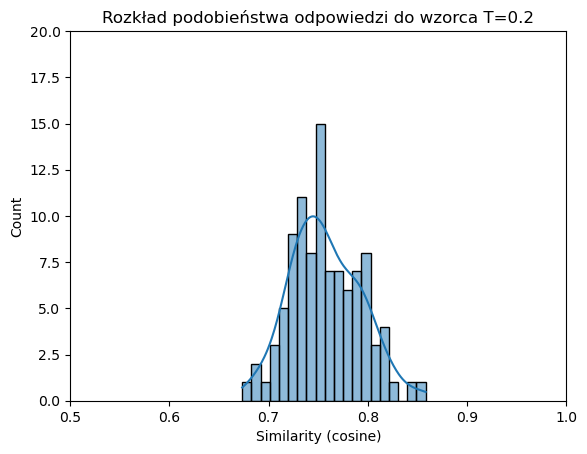

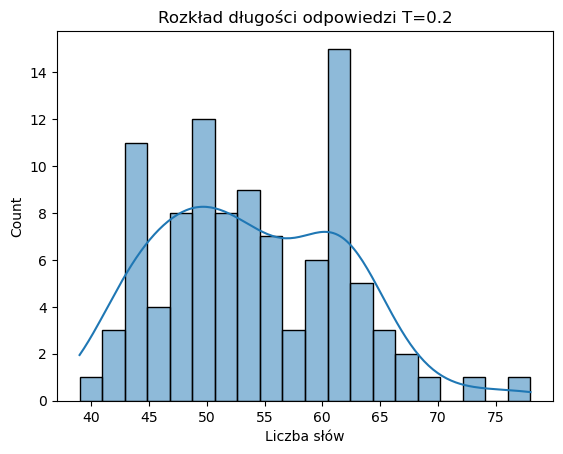

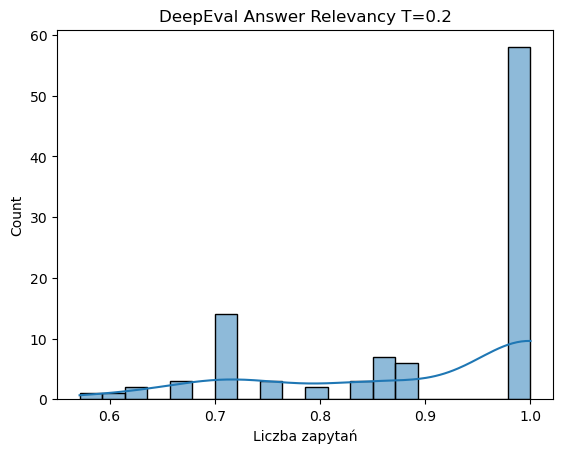

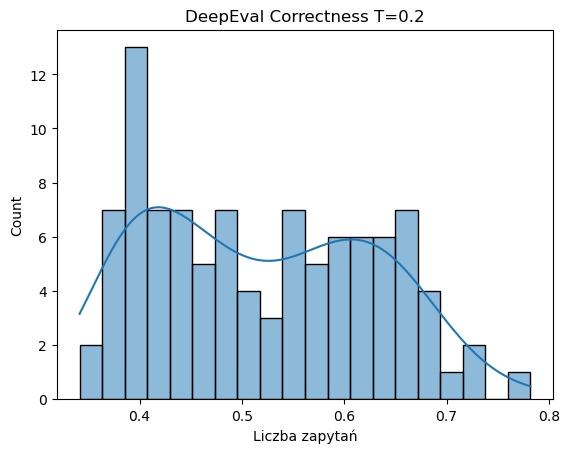

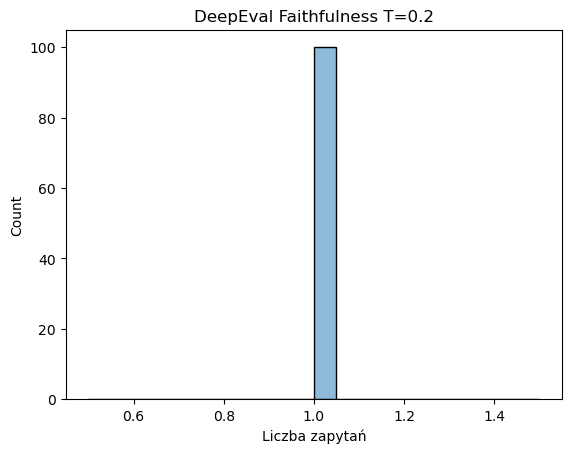

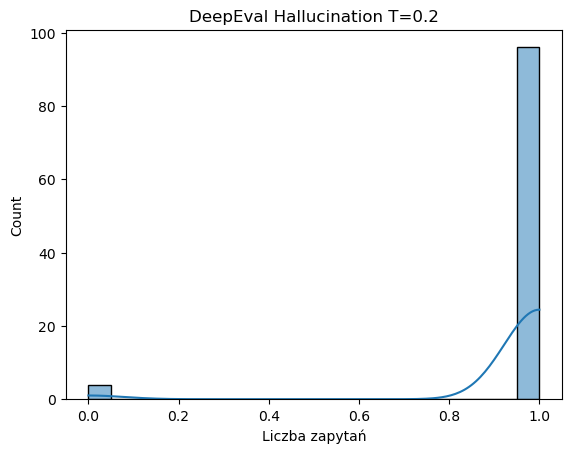

In [ ]:
# --- Analiza wyników ---
print("\n📊 Statystyki:")
print(df[["similarity", "length"]].describe())

# --- Wizualizacja ---
sns.histplot(df["similarity"], bins=20, kde=True)
plt.title(f"Rozkład podobieństwa odpowiedzi do wzorca T={TEMPERATURE}")
plt.xlabel("Similarity (cosine)")
plt.xlim(0.5, 1.0)
plt.ylim(0, 20)
plt.show()

sns.histplot(df["length"], bins=20, kde=True)
plt.title(f"Rozkład długości odpowiedzi T={TEMPERATURE}")
plt.xlabel("Liczba słów")
plt.show()

sns.histplot(df["answer_relevancy"], bins=20, kde=True)
plt.title(f"DeepEval Answer Relevancy T={TEMPERATURE}")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["correctness"], bins=20, kde=True)
plt.title(f"DeepEval Correctness T={TEMPERATURE}")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["faithfulness"], bins=20, kde=True)
plt.title(f"DeepEval Faithfulness T={TEMPERATURE}")
plt.xlabel("Liczba zapytań")
plt.show()

sns.histplot(df["hallucination"], bins=20, kde=True)
plt.title(f"DeepEval Hallucination T={TEMPERATURE}")
plt.xlabel("Liczba zapytań")
plt.show()